<a href="https://colab.research.google.com/github/M-Pascal/Data_Preprocessing_PLD_6/blob/main/Data_preprocessing%5Bpipeline%5D_PLD_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1:** Data Augmentation on CSV Files

In [553]:
# ===========================Import library===========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor

from imblearn.over_sampling import SMOTE
from scipy.stats import skew

In [ ]:
# Mounting drive on the notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This section focuses on expanding an existing dataset by generating synthetic data and applying augmentation techniques. It starts by loading a customer transaction dataset, followed by cleaning and handling missing values using imputation and predictive modeling. `Data augmentation` involves generating synthetic transactions, applying transformations like log scaling, and balancing data using ```SMOTE```. Then exporting the cleaned and augmented dataset for further processing.

In [848]:
path = '/content/drive/MyDrive/Y3_T1/Data_Preprocessing/dataset/customer_transactions.csv'
path_1 = '/content/drive/MyDrive/Y3_T1/Data_Preprocessing/dataset/customer_social_profiles.csv'
path_2 = '/content/drive/MyDrive/Y3_T1/Data_Preprocessing/dataset/id_mapping.csv'

df = pd.read_csv(path)

print(df.shape)
df.head()

(150, 6)


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


In [849]:
# checking for missing values
df.isnull().sum()

,0
customer_id_legacy,0
transaction_id,0
purchase_amount,0
purchase_date,0
product_category,0
customer_rating,10


In [850]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_legacy  150 non-null    int64  
 1   transaction_id      150 non-null    int64  
 2   purchase_amount     150 non-null    int64  
 3   purchase_date       150 non-null    object 
 4   product_category    150 non-null    object 
 5   customer_rating     140 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ KB


# Handling Missing Values

While handling missing values, we used LGBM model where the missing values were prediceted instead of imputing them. However through the process, depending on the number of the missing values, mean, median and mode imputations were made to be the methods of handling missing data. This is more effective because it reduced the number of sub- datasets and checks the best possible method along the way.

In [851]:
# dealing with missing value using LGBM model
cols_with_nans = [x for x in df.columns if df[x].isnull().sum() > 0]
cols_with_nans
# Checking how many missing value in it
df[cols_with_nans].isnull().sum()

,0
customer_rating,10


In [852]:
# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Handle missing values
for col in num_cols:
    missing_count = df[col].isnull().sum()

    if missing_count == 0:
        continue

    print(f"Handling missing values in: {col} ({missing_count} missing)")

    if missing_count > int(len(df) / 2):
        df.drop(col, axis=1, inplace=True)  # Drop if >50% missing
        print(f"Dropped {col} due to excessive missing values.")
    else:
        if missing_count <= 5:  # Small number of missing values, use median
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Filled {col} using Median Imputation.")
        else:
            # Use Predictive Modeling
            data = df.copy()
            nan_ixs = np.where(data[col].isna())[0]

            if len(nan_ixs) == 0:
                continue  # Skip if no missing values

            data["is_nan"] = 0
            data.loc[nan_ixs, "is_nan"] = 1

            # Convert categorical columns to numerical
            for cat_col in cat_cols:
                data[cat_col] = pd.factorize(data[cat_col])[0]

            train = data[data['is_nan'] == 0]
            test = data[data['is_nan'] == 1]

            x_train = train.drop(columns=[col, "is_nan"])
            y_train = train[col]
            x_test = test.drop(columns=[col, "is_nan"])

            if x_train.empty or x_test.empty:
                print(f"Skipping {col} due to insufficient data for modeling.")
                continue

            # Decision Tree Regression to predict missing values
            model = DecisionTreeRegressor(max_depth=5, random_state=42)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            df.loc[nan_ixs, col] = y_pred  # Fill missing values
            print(f"Filled {col} using Decision Tree Regression.")

# Handling missing categorical values
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with mode
        print(f"Filled {col} using Mode Imputation.")

Handling missing values in: customer_rating (10 missing)
Filled customer_rating using Decision Tree Regression.


In [853]:
df.isnull().sum()

,0
customer_id_legacy,0
transaction_id,0
purchase_amount,0
purchase_date,0
product_category,0
customer_rating,0


In [854]:
df.head(40)

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.300
1,192,1002,332,2024-01-02,Electronics,4.200
2,114,1003,442,2024-01-03,Electronics,2.100
3,171,1004,256,2024-01-04,Clothing,2.800
4,160,1005,64,2024-01-05,Clothing,1.300
5,120,1006,395,2024-01-06,Groceries,1.100
6,182,1007,91,2024-01-07,Sports,4.900
7,186,1008,429,2024-01-08,Clothing,4.300
8,174,1009,228,2024-01-09,Electronics,3.800
9,174,1010,112,2024-01-10,Sports,2.600


In [855]:

# Synthetic Data Generation
# Apply random noise to numerical transaction values
for col in df.select_dtypes(include=['number']).columns:
    noise = np.random.normal(0, 0.01 * df[col].std(), size=df.shape[0])  # Small Gaussian noise
    df[col] += noise
    print(f"Added noise to: {col}")

# Feature Value Transformation
# Identify skewed numerical columns and apply log transformation
num_cols = df.select_dtypes(include=['number']).columns
for col in num_cols:
    if abs(skew(df[col])) > 1:  # Check for skewness
        df[col] = np.log1p(df[col])  # Apply log transformation
        print(f"Applied log transformation to: {col}")

# Data Balancing using SMOTE
# Assuming the dataset has a categorical target variable
if "customer_segment" in df.columns:
    X = df.drop(columns=["customer_segment"])
    y = df["customer_segment"]

    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    df = pd.DataFrame(X_resampled, columns=X.columns)
    df["customer_segment"] = y_resampled

# Data Expansion (Generating Synthetic Transactions)
# Generate new transactions by sampling from existing patterns
num_synthetic_samples = int(0.2 * len(df))  # Generate 20% more synthetic data
synthetic_data = df.sample(n=num_synthetic_samples, replace=True).copy()

# Modify values slightly to create variability
for col in num_cols:
    synthetic_data[col] += np.random.normal(0, 0.02 * df[col].std(), size=num_synthetic_samples)

# Append synthetic data to original dataset
df = pd.concat([df, synthetic_data], ignore_index=True)
print(f"Generated {num_synthetic_samples} new synthetic transactions.")

# Export the Augmented Data
df.to_csv("customer_transactions_augmented.csv", index=False)
print("Data Augmentation Completed!")


Added noise to: customer_id_legacy
Added noise to: transaction_id
Added noise to: purchase_amount
Added noise to: customer_rating
Generated 30 new synthetic transactions.
Data Augmentation Completed!


In [856]:
print(df.shape)
df.head()

(180, 6)


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,150.740634,1000.540180,409.867303,2024-01-01,Sports,2.287885
1,191.693868,1001.445969,331.626726,2024-01-02,Electronics,4.215654
2,113.812252,1002.895530,440.248609,2024-01-03,Electronics,2.114811
3,170.354414,1004.464783,255.402970,2024-01-04,Clothing,2.798150
4,160.160417,1004.638622,64.031216,2024-01-05,Clothing,1.301073


# **Part 2:** Merging Datasets with Transitive Properties

The purpose is to merge two datasets that have indirect relationships through a third mapping file. The challenge arises from different customer ID systems across datasets. The process involves using an ID mapping file to establish links, merging transaction history with social media activity, and handling cases where multiple mappings exist. Additional feature engineering is performed to create predictive behavioral features like engagement scores, moving averages. The final merged dataset is then saved for further analysis toward Bonus challenge task as well.

In [857]:
# reading the saved dataset from part_1
df_transaction = pd.read_csv("customer_transactions_augmented.csv")
df_transaction.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,150.740634,1000.540180,409.867303,2024-01-01,Sports,2.287885
1,191.693868,1001.445969,331.626726,2024-01-02,Electronics,4.215654
2,113.812252,1002.895530,440.248609,2024-01-03,Electronics,2.114811
3,170.354414,1004.464783,255.402970,2024-01-04,Clothing,2.798150
4,160.160417,1004.638622,64.031216,2024-01-05,Clothing,1.301073


In [858]:
# reading the customer social media profile dataset
df_social = pd.read_csv(path_1)
df_social.head()

,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral


In [859]:
# read the id_mapping dataset
df_id = pd.read_csv(path_2)
df_id.head()

,customer_id_legacy,customer_id_new
0,195,A105
1,161,A118
2,192,A156
3,157,A168
4,166,A102


In [860]:
# finding the link between the dataset

# Convert customer_id_legacy to int in both dataframes
df_transaction["customer_id_legacy"] = df_transaction["customer_id_legacy"].astype(int)
df_id["customer_id_legacy"] = df_id["customer_id_legacy"].astype(int)

# Check for missing values in customer_id_legacy
print("Missing values in df_transaction:", df_transaction["customer_id_legacy"].isnull().sum())
print("Missing values in df_id:", df_id["customer_id_legacy"].isnull().sum())

# Check for unique values in customer_id_legacy
print("Unique values in df_transaction:", df_transaction["customer_id_legacy"].nunique())
print("Unique values in df_id:", df_id["customer_id_legacy"].nunique())

# Check if all values in df_transaction exist in df_id
missing_ids = df_transaction[~df_transaction["customer_id_legacy"].isin(df_id["customer_id_legacy"])]
print("Rows in df_transaction with no matching customer_id_legacy in df_id:", len(missing_ids))

Missing values in df_transaction: 0
Missing values in df_id: 0
Unique values in df_transaction: 78
Unique values in df_id: 79
Rows in df_transaction with no matching customer_id_legacy in df_id: 42


In [861]:
# Get the mismatched customer_id_legacy values
mismatched_ids = df_transaction[~df_transaction["customer_id_legacy"].isin(df_id["customer_id_legacy"])]["customer_id_legacy"].unique()
print("Mismatched customer_id_legacy values:", mismatched_ids)

Mismatched customer_id_legacy values: [160 185 156 148 153 172 117 107 143 133 102 100 142 171 184 124  99 168]


In [862]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Read the provided datasets

# Load customer transactions dataset
transaction_df = pd.read_csv("customer_transactions_augmented.csv")

# Load customer social media profiles dataset
df_social = pd.read_csv(path_1)

# Load ID mapping dataset
df_id = pd.read_csv(path_2)

In [863]:
# Step 2: Find the Link Between Datasets
# Convert customer_id_legacy in both datasets to int for consistency
transaction_df["customer_id_legacy"] = transaction_df["customer_id_legacy"].astype(int)
df_id["customer_id_legacy"] = df_id["customer_id_legacy"].astype(int)

# Merge transaction data with ID mapping to get customer_id_new
merged_transactions = transaction_df.merge(df_id, on="customer_id_legacy", how="left")

# Merge with social media data using customer_id_new
full_data = merged_transactions.merge(df_social, on="customer_id_new", how="left")

In [864]:
# Step 3: Handle conflicts where one customer ID maps to multiple entries
# Identify conflicted legacy IDs with multiple mappings
conflicted_legacy_ids = merged_transactions[merged_transactions.duplicated(subset="customer_id_legacy", keep=False)]
print("Conflicted legacy IDs:", conflicted_legacy_ids["customer_id_legacy"].unique())

# Sort by purchase_date and keep the most recent mapping
merged_transactions = merged_transactions.sort_values(by="purchase_date", ascending=False)
merged_transactions = merged_transactions.drop_duplicates(subset="customer_id_legacy", keep="first")

Conflicted legacy IDs: [150 191 113 170 160 119 185 173 186 199 122 101 121 151 128 136 162 158
 120 132 175 188 148 190 141 179 161 145 149 163 105 172 138 103 187 159
 107 183 143 133 176 180 134 102 104 152 116 198 146 171 177 184 181 127
  99 109 139 106 111 131 112 197 126]


In [865]:
# Step 4: Feature Engineering & Transformation

# Convert purchase_date to datetime format
full_data["purchase_date"] = pd.to_datetime(full_data["purchase_date"], errors='coerce')

# Extract time-based features
full_data["transaction_month"] = full_data["purchase_date"].dt.month
full_data["transaction_weekday"] = full_data["purchase_date"].dt.weekday  # 0 = Monday, 6 = Sunday

# Aggregate purchase amounts by month
monthly_agg = full_data.groupby(["customer_id_new", "transaction_month"])["purchase_amount"].agg(["sum", "mean"]).reset_index()
monthly_agg.rename(columns={"sum": "purchase_amount_monthly", "mean": "purchase_avg_monthly"}, inplace=True)

# Aggregate purchase amounts by weekday
weekday_agg = full_data.groupby(["customer_id_new", "transaction_weekday"])["purchase_amount"].agg(["sum", "mean"]).reset_index()
weekday_agg.rename(columns={"sum": "purchase_amount_weekday", "mean": "purchase_avg_weekday"}, inplace=True)

# Merge aggregated features back into the dataset
full_data = full_data.merge(monthly_agg, on=["customer_id_new", "transaction_month"], how="left", suffixes=("", "_monthly"))
full_data = full_data.merge(weekday_agg, on=["customer_id_new", "transaction_weekday"], how="left", suffixes=("", "_weekday"))

# Normalize engagement score and purchase interest score
scaler = MinMaxScaler()
full_data[["engagement_score", "purchase_interest_score"]] = scaler.fit_transform(full_data[["engagement_score", "purchase_interest_score"]])

# Compute new Customer Engagement Score (CES) as weighted sum
full_data["customer_engagement_score"] = (0.6 * full_data["engagement_score"]) + (0.4 * full_data["purchase_interest_score"])

In [866]:
# checkin the dataframe
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id_legacy         472 non-null    int64         
 1   transaction_id             472 non-null    float64       
 2   purchase_amount            472 non-null    float64       
 3   purchase_date              472 non-null    datetime64[ns]
 4   product_category           472 non-null    object        
 5   customer_rating            472 non-null    float64       
 6   customer_id_new            430 non-null    object        
 7   social_media_platform      381 non-null    object        
 8   engagement_score           381 non-null    float64       
 9   purchase_interest_score    381 non-null    float64       
 10  review_sentiment           381 non-null    object        
 11  transaction_month          472 non-null    int32         
 12  transact

In [867]:
# Step 5: TF-IDF Transformation on Social Media Comments
if "comments" in full_data.columns:
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf_vectorizer.fit_transform(full_data["comments"].fillna(""))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    full_data = pd.concat([full_data.reset_index(drop=True), tfidf_df], axis=1)

In [868]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id_legacy         472 non-null    int64         
 1   transaction_id             472 non-null    float64       
 2   purchase_amount            472 non-null    float64       
 3   purchase_date              472 non-null    datetime64[ns]
 4   product_category           472 non-null    object        
 5   customer_rating            472 non-null    float64       
 6   customer_id_new            430 non-null    object        
 7   social_media_platform      381 non-null    object        
 8   engagement_score           381 non-null    float64       
 9   purchase_interest_score    381 non-null    float64       
 10  review_sentiment           381 non-null    object        
 11  transaction_month          472 non-null    int32         
 12  transact

In [869]:
# Step 6: Handle missing mappings (drop rows where no mapping exists)
full_data.dropna(subset=["customer_id_new"], inplace=True)

# Step 7: Save the final preprocessed dataset
final_filename = "final_customer_data_PLD_6.csv"
full_data.to_csv(final_filename, index=False)
print(f"\nDatasets successfully linked and saved as '{final_filename}'")


Datasets successfully linked and saved as 'final_customer_data_PLD_6.csv'


In [870]:
full_data.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
0,150,1000.540180,409.867303,2024-01-01,Sports,2.287885,A143,Instagram,0.367347,0.050,Negative,1,0,409.867303,409.867303,409.867303,409.867303,0.240408
1,191,1001.445969,331.626726,2024-01-02,Electronics,4.215654,A114,Facebook,0.755102,0.950,Negative,1,1,331.626726,331.626726,331.626726,331.626726,0.833061
2,191,1001.445969,331.626726,2024-01-02,Electronics,4.215654,A102,LinkedIn,0.020408,0.950,Neutral,1,1,331.626726,331.626726,331.626726,331.626726,0.392245
3,113,1002.895530,440.248609,2024-01-03,Electronics,2.114811,A196,Instagram,0.714286,0.725,Negative,1,2,440.248609,440.248609,930.613470,465.306735,0.718571
4,170,1004.464783,255.402970,2024-01-04,Clothing,2.798150,A181,Twitter,0.326531,0.275,Positive,1,3,331.773317,165.886659,369.228312,184.614156,0.305918


In [871]:
df_final = pd.read_csv("final_customer_data_PLD_6.csv")
df_final.tail()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
425,134,1069.021009,364.230899,2024-03-10,Electronics,2.173908,A120,Instagram,0.857143,0.650,Positive,3,6,2186.084599,364.347433,2186.084599,364.347433,0.774286
426,163,1044.044247,494.770560,2024-02-13,Sports,3.000189,A180,Facebook,0.142857,0.700,Negative,2,1,1971.507795,492.876949,2687.517612,447.919602,0.365714
427,163,1044.044247,494.770560,2024-02-13,Sports,3.000189,A180,LinkedIn,0.979592,0.275,Negative,2,1,1971.507795,492.876949,2687.517612,447.919602,0.697755
428,163,1044.044247,494.770560,2024-02-13,Sports,3.000189,A131,LinkedIn,0.755102,0.500,Positive,2,1,1374.398039,458.132680,1343.758806,447.919602,0.653061
429,163,1044.044247,494.770560,2024-02-13,Sports,3.000189,A101,Twitter,0.367347,0.000,Neutral,2,1,1141.844858,380.614953,1343.758806,447.919602,0.220408


In [872]:
print(df_final.shape)

(430, 18)


# **Part 3:** Data Consistency and Quality Checks

This section ensures the final dataset is clean, structured, and ready for machine learning. It includes integrity checks to remove duplicates, validate categorical values, and confirm all transactions have matching social profiles. Statistical summarization helps analyze numerical data distributions. Feature selection techniques, such as correlation heatmaps and importance ranking, are applied to refine the dataset. Finally, the fully processed dataset is exported, ensuring it meets the necessary quality standards.

In [873]:
# Load the preprocessed dataset
full_data = pd.read_csv("final_customer_data_PLD_6.csv")
full_data.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
0,150,1000.540180,409.867303,2024-01-01,Sports,2.287885,A143,Instagram,0.367347,0.050,Negative,1,0,409.867303,409.867303,409.867303,409.867303,0.240408
1,191,1001.445969,331.626726,2024-01-02,Electronics,4.215654,A114,Facebook,0.755102,0.950,Negative,1,1,331.626726,331.626726,331.626726,331.626726,0.833061
2,191,1001.445969,331.626726,2024-01-02,Electronics,4.215654,A102,LinkedIn,0.020408,0.950,Neutral,1,1,331.626726,331.626726,331.626726,331.626726,0.392245
3,113,1002.895530,440.248609,2024-01-03,Electronics,2.114811,A196,Instagram,0.714286,0.725,Negative,1,2,440.248609,440.248609,930.613470,465.306735,0.718571
4,170,1004.464783,255.402970,2024-01-04,Clothing,2.798150,A181,Twitter,0.326531,0.275,Positive,1,3,331.773317,165.886659,369.228312,184.614156,0.305918


In [874]:
full_data.shape

(430, 18)

In [875]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id_legacy         430 non-null    int64  
 1   transaction_id             430 non-null    float64
 2   purchase_amount            430 non-null    float64
 3   purchase_date              430 non-null    object 
 4   product_category           430 non-null    object 
 5   customer_rating            430 non-null    float64
 6   customer_id_new            430 non-null    object 
 7   social_media_platform      381 non-null    object 
 8   engagement_score           381 non-null    float64
 9   purchase_interest_score    381 non-null    float64
 10  review_sentiment           381 non-null    object 
 11  transaction_month          430 non-null    int64  
 12  transaction_weekday        430 non-null    int64  
 13  purchase_amount_monthly    430 non-null    float64

## Data Integrity Checks

In [876]:
# Check for duplicate entries
duplicates = full_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
full_data.drop_duplicates(inplace=True)

Number of duplicate rows: 20


In [877]:
full_data.shape

(410, 18)

In [878]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410 entries, 0 to 429
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id_legacy         410 non-null    int64  
 1   transaction_id             410 non-null    float64
 2   purchase_amount            410 non-null    float64
 3   purchase_date              410 non-null    object 
 4   product_category           410 non-null    object 
 5   customer_rating            410 non-null    float64
 6   customer_id_new            410 non-null    object 
 7   social_media_platform      363 non-null    object 
 8   engagement_score           363 non-null    float64
 9   purchase_interest_score    363 non-null    float64
 10  review_sentiment           363 non-null    object 
 11  transaction_month          410 non-null    int64  
 12  transaction_weekday        410 non-null    int64  
 13  purchase_amount_monthly    410 non-null    float64
 14 

In [879]:
# Ensure categorical values are correctly mapped
print("Categorical column value counts:")
categorical_columns = ["product_category", "social_media_platform", "review_sentiment"]
for col in categorical_columns:
    print(f"{col}:")
    print(full_data[col].value_counts())

Categorical column value counts:
product_category:
product_category
Electronics    119
Sports          84
Groceries       81
Clothing        71
Books           55
Name: count, dtype: int64
social_media_platform:
social_media_platform
LinkedIn     90
TikTok       81
Facebook     74
Twitter      64
Instagram    54
Name: count, dtype: int64
review_sentiment:
review_sentiment
Positive    135
Neutral     121
Negative    107
Name: count, dtype: int64


In [880]:
# Validate that all customer transactions match a valid social profile
missing_social_profiles = full_data[full_data["customer_id_new"].isnull()]
print(f"Transactions without a valid social profile: {len(missing_social_profiles)}")

Transactions without a valid social profile: 0


In [881]:
# Generate describe() report for numerical columns
print("Statistical Summary of Numerical Columns:")
full_data.describe()

Statistical Summary of Numerical Columns:


,customer_id_legacy,transaction_id,purchase_amount,customer_rating,engagement_score,purchase_interest_score,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
count,410.000000,410.000000,410.000000,410.000000,363.000000,363.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,363.000000
mean,150.248780,1075.294498,279.319870,2.857244,0.545961,0.544284,2.973171,3.109756,1409.399457,279.721115,1347.572394,279.493027,0.545290
std,30.264467,45.058685,118.108030,1.165208,0.302447,0.275496,1.516579,1.844877,1319.152672,106.420556,1290.604773,101.139885,0.218645
min,101.000000,1000.540180,60.192028,0.998149,0.000000,0.000000,1.000000,0.000000,86.343087,60.982912,76.370347,76.370347,0.000000
25%,122.000000,1032.215838,188.286822,1.820247,0.326531,0.350000,2.000000,2.000000,448.892949,197.369906,444.336863,197.855819,0.389184
50%,149.500000,1077.062849,280.461269,2.816746,0.551020,0.575000,3.000000,3.000000,841.225188,296.299083,820.958853,279.963422,0.550612
75%,179.000000,1117.874575,373.101946,3.903808,0.795918,0.750000,4.000000,5.000000,1896.057080,364.347433,1851.469422,361.914506,0.718571
max,199.000000,1150.137240,494.979533,5.009401,1.000000,1.000000,5.000000,6.000000,5022.445800,494.979533,5296.927266,494.979533,0.920000


## Feature Selection for Machine Learning

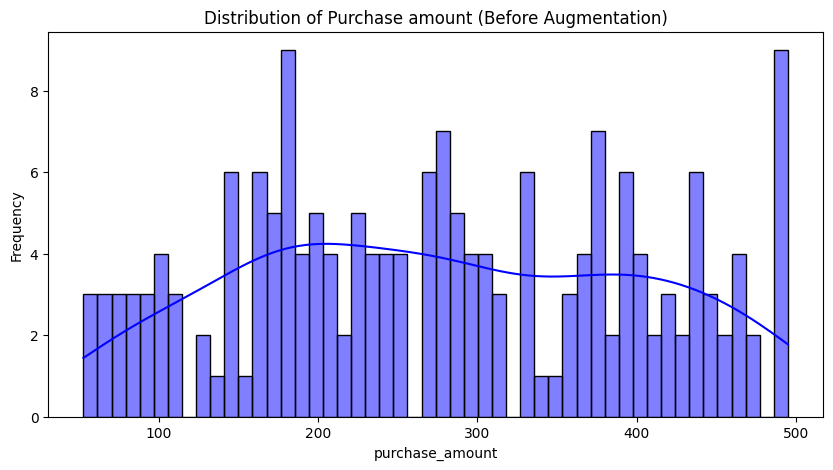

In [882]:
# # Visualize the distribution of Purchase amount before augmentation
plt.figure(figsize=(10, 5))
sns.histplot(df["purchase_amount"], bins=50, kde=True, color="blue")
plt.title("Distribution of Purchase amount (Before Augmentation)")
plt.xlabel("purchase_amount")
plt.ylabel("Frequency")
plt.show()

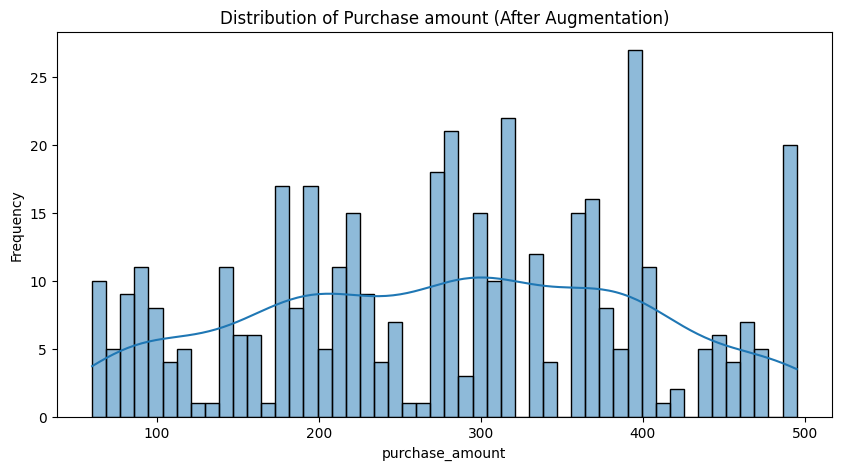

In [883]:
# Visualize the distribution of Purchase amount after augmentation
plt.figure(figsize=(10, 5))
sns.histplot(full_data["purchase_amount"], bins=50, kde=True)
plt.title("Distribution of Purchase amount (After Augmentation)")
plt.xlabel("purchase_amount")
plt.ylabel("Frequency")
plt.show()

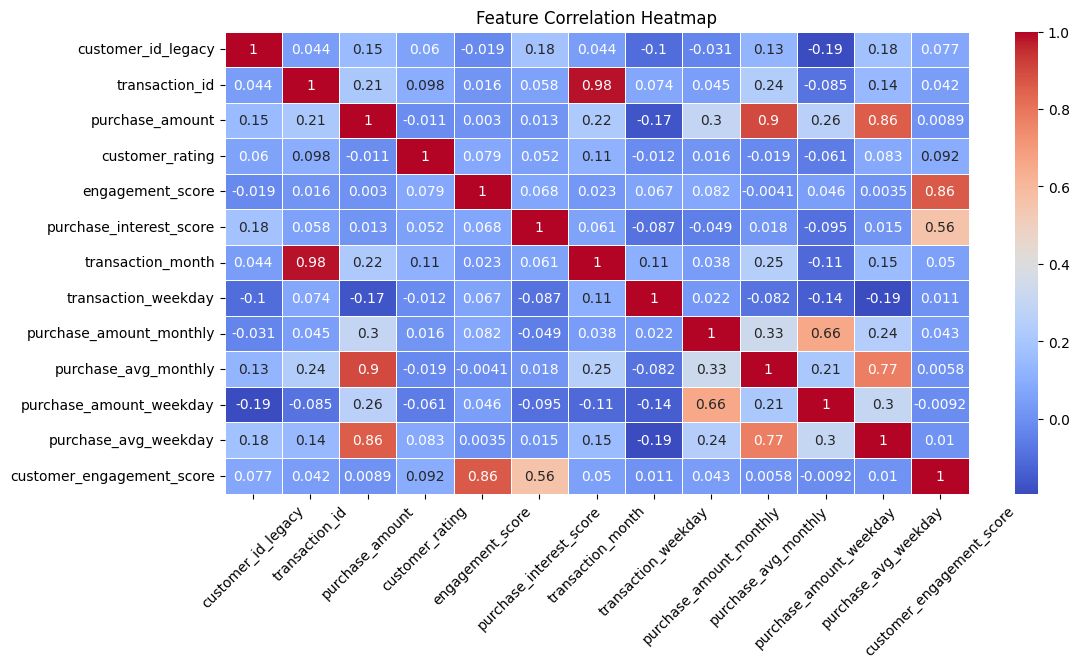

In [884]:
# Identify highly correlated features using a correlation heatmap

# Selecting only numeric columns for correlation
numeric_df = full_data.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()


## Selecting the top most important features using SelectKBest

In [885]:
# Identify Non-Numeric Columns
non_numeric_cols = full_data.select_dtypes(exclude=['number']).columns
print("Non-Numeric Columns:", non_numeric_cols.tolist())

# Drop Irrelevant Columns (IDs, Dates)
columns_to_drop = ["customer_id_new", "customer_id_legacy", "purchase_date"]
full_data = full_data.drop(columns=columns_to_drop, errors='ignore')

# Convert Categorical Features into Numeric
label_encoders = {}
for col in full_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col].astype(str))  # Convert NaN to string for encoding
    label_encoders[col] = le

# Handle Missing Values
imputer = SimpleImputer(strategy="mean")  # Fill NaN with column mean (Change to "median" or "most_frequent" if needed)
full_data = pd.DataFrame(imputer.fit_transform(full_data), columns=full_data.columns)

# Define Features (X) and Target (y)
X = full_data.drop(columns=["purchase_interest_score"], errors='ignore')
y = full_data["purchase_interest_score"]

# Feature Selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_new = selector.fit_transform(X, y)

# Display Selected Features
selected_features = X.columns[selector.get_support()]
print("Top selected features:", selected_features.tolist())


Non-Numeric Columns: ['purchase_date', 'product_category', 'customer_id_new', 'social_media_platform', 'review_sentiment']
Top selected features: ['customer_rating', 'social_media_platform', 'engagement_score', 'review_sentiment', 'transaction_weekday', 'purchase_amount_monthly', 'purchase_avg_monthly', 'purchase_amount_weekday', 'purchase_avg_weekday', 'customer_engagement_score']


In [886]:
# Save the final dataset for machine learning
final_filename = "final_dataset_ready_PLD_6.csv"
full_data.to_csv(final_filename, index=False)
print(f"Final dataset saved as '{final_filename}'")

Final dataset saved as 'final_dataset_ready_PLD_6.csv'


In [887]:
# Reading the saved cleaned data (encodered data)
df_clean = pd.read_csv("final_dataset_ready_PLD_6.csv")
df_clean.tail()

,transaction_id,purchase_amount,product_category,customer_rating,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
405,1069.021009,364.230899,2.0,2.173908,1.0,0.857143,0.650,2.0,3.0,6.0,2186.084599,364.347433,2186.084599,364.347433,0.774286
406,1044.044247,494.770560,4.0,3.000189,0.0,0.142857,0.700,0.0,2.0,1.0,1971.507795,492.876949,2687.517612,447.919602,0.365714
407,1044.044247,494.770560,4.0,3.000189,2.0,0.979592,0.275,0.0,2.0,1.0,1971.507795,492.876949,2687.517612,447.919602,0.697755
408,1044.044247,494.770560,4.0,3.000189,2.0,0.755102,0.500,2.0,2.0,1.0,1374.398039,458.132680,1343.758806,447.919602,0.653061
409,1044.044247,494.770560,4.0,3.000189,4.0,0.367347,0.000,1.0,2.0,1.0,1141.844858,380.614953,1343.758806,447.919602,0.220408


In [888]:
df_clean.shape

(410, 15)

In [889]:
# checking missing value
df_clean.isnull().sum()

,0
transaction_id,0
purchase_amount,0
product_category,0
customer_rating,0
social_media_platform,0
engagement_score,0
purchase_interest_score,0
review_sentiment,0
transaction_month,0
transaction_weekday,0


In [890]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             410 non-null    float64
 1   purchase_amount            410 non-null    float64
 2   product_category           410 non-null    float64
 3   customer_rating            410 non-null    float64
 4   social_media_platform      410 non-null    float64
 5   engagement_score           410 non-null    float64
 6   purchase_interest_score    410 non-null    float64
 7   review_sentiment           410 non-null    float64
 8   transaction_month          410 non-null    float64
 9   transaction_weekday        410 non-null    float64
 10  purchase_amount_monthly    410 non-null    float64
 11  purchase_avg_monthly       410 non-null    float64
 12  purchase_amount_weekday    410 non-null    float64
 13  purchase_avg_weekday       410 non-null    float64

# **Part_4:** Model training

In this Bonus challenge, a machine learning model is applied to predict customer spending behavior based on the merged and processed dataset. The process begins by selecting a suitable algorithm, such as Linear Regression, Random Forest, or XGBoost; But for us we chosed to use `Linear Regression`. The dataset is split into training and testing sets, and feature selection ensures that only relevant variables are used. The chosen model is trained on historical transaction and social engagement data, then evaluated using appropriate metrics like RMSE, R2_score.

In [891]:
# Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [892]:
# Define Features (X) and Target (y)
X = df_clean.drop(columns=["purchase_amount"])
y = df_clean["purchase_amount"]

# Split Data into Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [893]:
# Train Models & Evaluate
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [894]:
# Predictions
y_pred = model.predict(X_test)

In [895]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

Mean Absolute Error (MAE): 28.00
Mean Squared Error (MSE): 1603.19
Root Mean Squared Error (RMSE): 40.04
R2 Score: 0.8379


# **Done By:**
1. Pascal Mugisha
2. Jean Chrisostome Dufitumukiza
3. Ruth Iradukunda

In [896]:
# =========================================The End=========================================